# **Lane Line Detection for Autonomous Cars** 
***

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Images

Built my pipeline to work on the images in the directory "test_images"

In [2]:
import os

# print test images file name
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

#### Read in a Test Image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


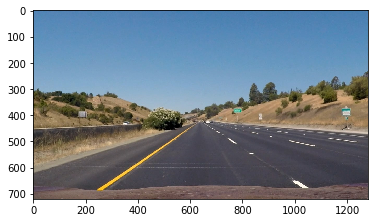

In [3]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

# printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image) 

# Camera Calibration

Calculate the correct camera matrix and distortion coefficients using the calibration chessboard images in the directory "camera_cal"

In [4]:
# list of calibration images file names
os.listdir("camera_cal/") 

['calibration1.jpg',
 'calibration10.jpg',
 'calibration11.jpg',
 'calibration12.jpg',
 'calibration13.jpg',
 'calibration14.jpg',
 'calibration15.jpg',
 'calibration16.jpg',
 'calibration17.jpg',
 'calibration18.jpg',
 'calibration19.jpg',
 'calibration2.jpg',
 'calibration20.jpg',
 'calibration3.jpg',
 'calibration4.jpg',
 'calibration5.jpg',
 'calibration6.jpg',
 'calibration7.jpg',
 'calibration8.jpg',
 'calibration9.jpg']

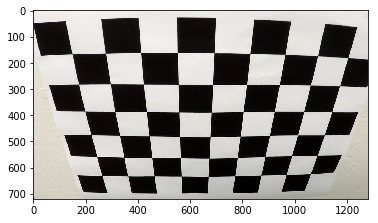

In [5]:
# show one of the calibration images
img = mpimg.imread('camera_cal/calibration9.jpg')
plt.imshow(img)

## Finding Corners in Calibration Images

In [6]:
print('Finding corners in all calibration images...')

# Arrays to store object points and image points from all the calibration images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (9,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates

nx = 9 # number of chessboard inside corners in x
ny = 6 # number of chessboard inside corners in y
    
# Make a list of calibration images file names
calibration_images_names = os.listdir("camera_cal/")

for calibration_image_name in calibration_images_names:
    # Read each image
    img = cv2.imread('camera_cal/' + calibration_image_name)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If corners are found
    if ret == True:
        # add object points, image points
        imgpoints.append(corners)
        objpoints.append(objp)

print('Successfully found corners in all calibration images')

Finding corners in all calibration images...
Successfully found corners in all calibration images


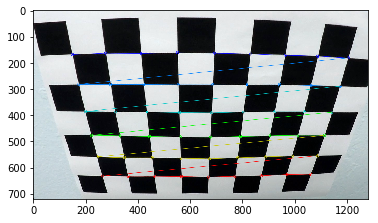

In [7]:
# Draw and display the corners in the last calibration image as an example
img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
plt.imshow(img)

## Correcting for Distortion

In [8]:
# This function takes an image, object points, and image points,
# performs the camera calibration and image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#### Test distortion correction on a checkboard image

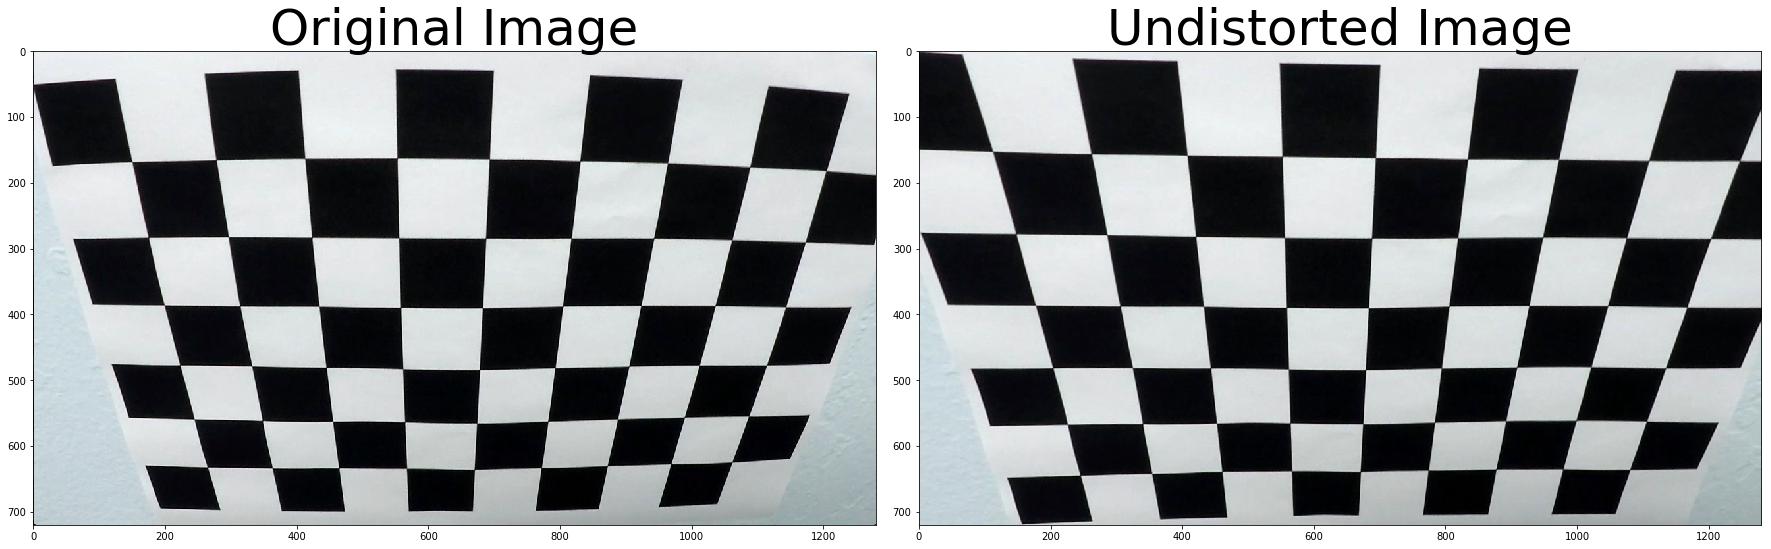

In [9]:
# Read image
img = cv2.imread('camera_cal/calibration9.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# plot original and unsdistorted images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Test distortion correction on a test image

Undistorted image saved in output_images directory.


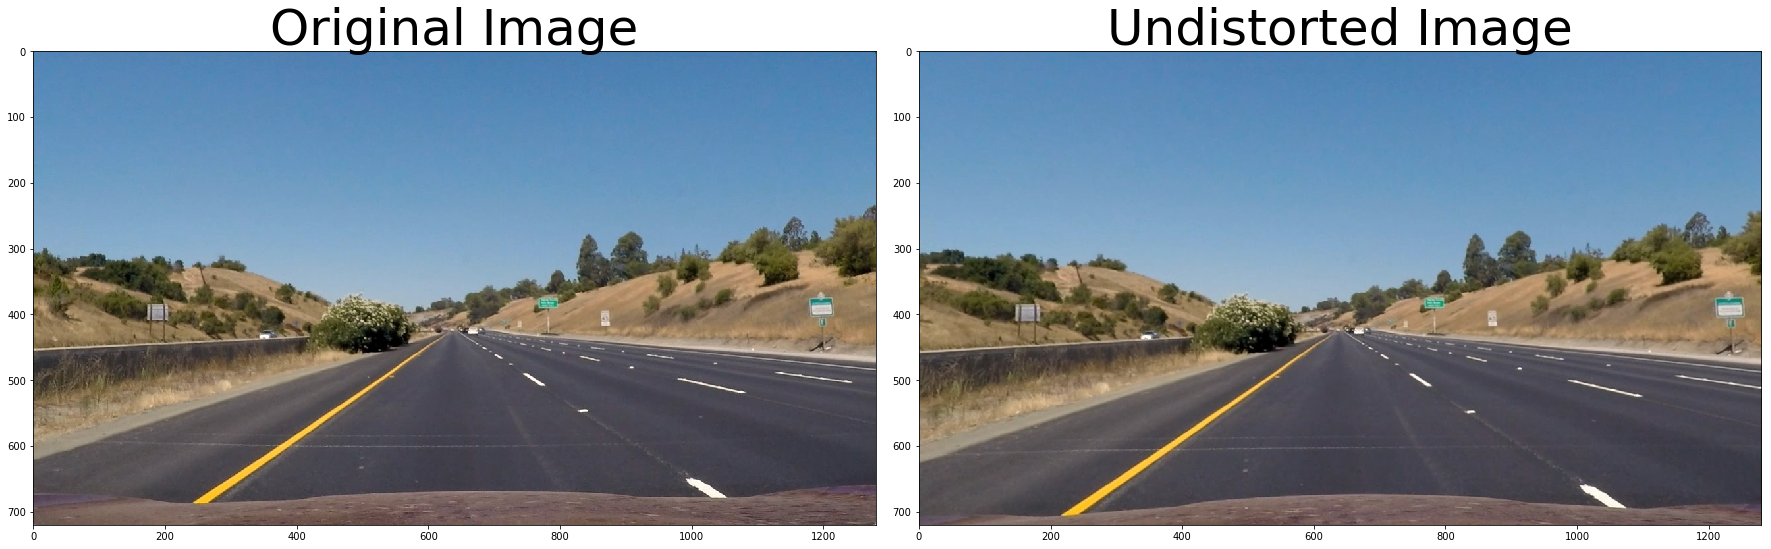

In [10]:
# Read image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# save undistorted image in 'output_images' folder
image_to_write = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines1-undistorted.jpg', image_to_write)
print('Undistorted image saved in output_images directory.')

# plot original and undistorted images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

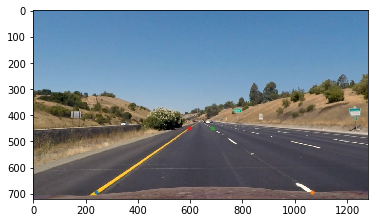

In [11]:
# Read undistorted test image
img = mpimg.imread('output_images/straight_lines1-undistorted.jpg')

# set the source coordinates of the lane line
plt.imshow(img)
plt.plot(240,695,'.') # bottom left
plt.plot(1065,695,'.') # bottom right
plt.plot(685,450,'.') # top right
plt.plot(595,450,'.') # top left

#### This function takes an undistorted image and returns the warped image

In [12]:
def warp(undist):
    
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    
    # Define calibration box in source (original) and destination (warped) coordinates
    src = np.float32(
        [[240,695], # bottom left
         [1065,695],  # bottom right
         [685,450], # top right
         [595,450]]) # top left
    dst = np.float32(
        [[240,720], # bottom left
         [1065,720],  # bottom right
         [1065,0], # top right
         [240,0]]) # top left
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped

#### Test perspective transform on a test image

Warped image saved in output_images directory.


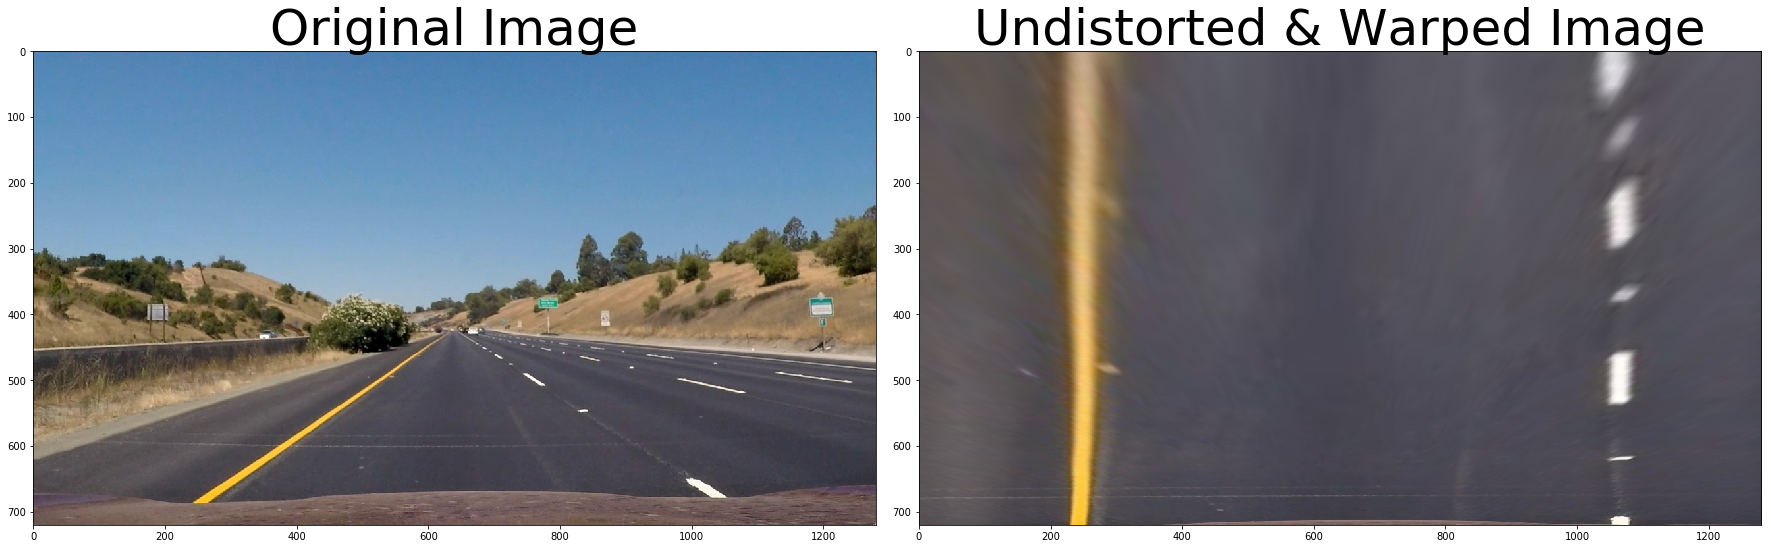

In [13]:
# Read original image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Return warped image
warped = warp(undistorted)

# Save warped image in 'output_images' folder
image_to_write = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines1-warped.jpg', image_to_write)
print('Warped image saved in output_images directory.')

# Plot original and undistorted & warped images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted & Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Gradient Thresholding

#### This function takes a warped image, applies Sobel x and y,  then computes the magnitude of the gradient, applies a threshold and returns the gradient threshold binary output

In [20]:
def magnitude_threshold(warped, sobel_kernel=3, mag_thresh=(0, 255)):

    # Convert to grayscale
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

#### This function takes a warped image, applies Sobel x and y,  then computes the direction of the gradient, applies a threshold and returns the gradient threshold binary output

In [21]:
def direction_threshold(warped, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the absolute value of the gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create a mask of 1's where the absolute value of the gradient direction 
            # is > thresh_min and < thresh_max
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

#### Test Gradient Magnitude and Gradient  Direction Thresholdings on a warped test image

Combined Gradient thresholdings binary image saved in output_images directory.


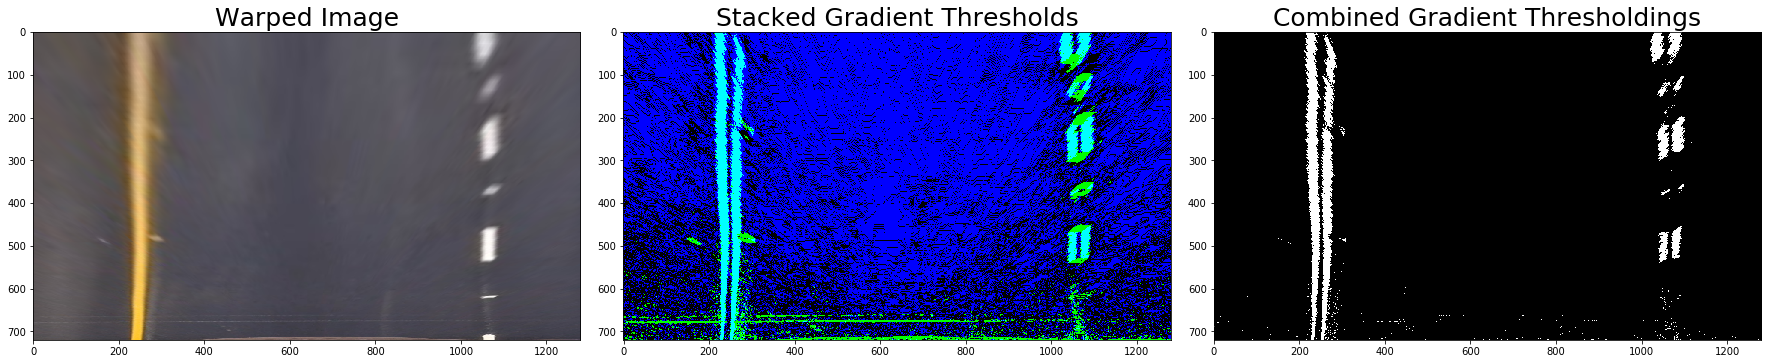

In [25]:
# Read original image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Return warped image
warped = warp(undistorted)

# Perform gradient magnitude thresholding
mag_binary = magnitude_threshold(warped, sobel_kernel=1, mag_thresh=(5,75))

# Perform gradient direction thresholding for vertical lines
dir_vertical_binary = direction_threshold(warped, sobel_kernel=1, thresh=(0, 0.6))

# Stack each gradient thresholding to view their individual contributions 
  # in green (magnitude threshold) and blue (direction threshold)
gradient_contribution_binary = np.dstack(( np.zeros_like(mag_binary), mag_binary, dir_vertical_binary))

# Combine gradient magnitude and gradient direction thresholdings
gradient_binary = np.zeros_like(mag_binary)
gradient_binary[(mag_binary == 1) & (dir_vertical_binary == 1)] = 1

# Save combined gradient binary image in 'output_images' folder
# image_to_write = cv2.cvtColor(gradient_binary, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines1-gradient.jpg', gradient_binary)
print('Combined Gradient thresholdings binary image saved in output_images directory.')

# plot warped and combined gradient thresholdings binary images side by side
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=25)
ax2.imshow(gradient_contribution_binary, cmap='gray')
ax2.set_title('Stacked Gradient Thresholds', fontsize=25)
ax3.imshow(gradient_binary, cmap='gray')
ax3.set_title('Combined Gradient Thresholdings', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Color Thresholding
Use S-channel thresholding for yellow lines and R-channel thresholding for white lines

#### This function takes a warped image, converts it from RGB to HLS color space, filters on the saturation channel, applies a threshold and returns the saturation threshold binary output

In [35]:
def saturation_threshold(warped, thresh=(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    
    # Filter on the S-channel from the HLS color space
    S = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(S) 
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary_output

#### This function takes a warped image, filters on the red channel, applies a threshold and returns the red threshold binary output

In [36]:
def red_threshold(warped, thresh=(0, 255)):
    
    # Filter on the red channel from the RGB color space
    R = warped[:,:,0]
    
    # Apply a threshold to the red channel
    binary_output = np.zeros_like(R) 
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return binary_output

#### Test Saturation and Red Thresholdings on a warped test image

Combined Color thresholdings binary image saved in output_images directory.


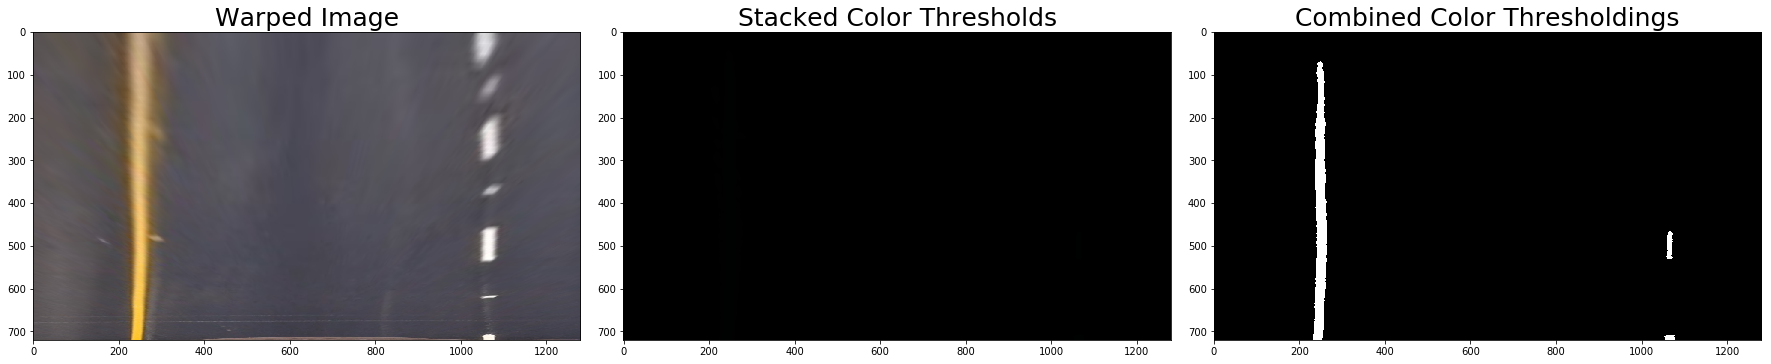

In [41]:
# Read original image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Return warped image
warped = warp(undistorted)

# Perform saturation-channel thresholding for yellow lines
s_binary = saturation_threshold(warped, thresh=(90, 255))

# Perform red-channel thresholding for white lines
r_binary = red_threshold(warped, thresh=(200, 255))

# Stack each color thresholding to view their individual contributions
    # in green (saturation-channel) and blue (red-channel) 
color_contribution_binary = np.dstack(( np.zeros_like(s_binary), s_binary, r_binary))

# Combine saturation-channel and red-channel thresholdings
color_binary = np.zeros_like(s_binary)
color_binary[(s_binary == 1) & (r_binary == 1)] = 1

# Save combined color thresholds binary image in 'output_images' folder
# image_to_write = cv2.cvtColor(color_binary, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines1-color.jpg', color_binary)
print('Combined Color thresholdings binary image saved in output_images directory.')

# plot warped and combined color thresholdings binary images side by side
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=25)
ax2.imshow(color_contribution_binary, cmap='gray')
ax2.set_title('Stacked Color Thresholds', fontsize=25)
ax3.imshow(color_binary, cmap='gray')
ax3.set_title('Combined Color Thresholdings', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)